# Mục 5: Thí nghiệm Adam và Ví dụ

## Tổng quan và Mục tiêu

### Mục tiêu
Mục đích của thí nghiệm này là phân tích một cách có hệ thống và so sánh hiệu quả của các thuật toán tối ưu khác nhau trong việc huấn luyện mạng nơ-ron. Đặc biệt, chúng tôi tập trung vào bộ tối ưu Adam, xem xét hiệu suất của nó so với Gradient Descent cổ điển, Stochastic Gradient Descent, Adadelta, Adagrad và RMSProp. Bằng cách tiến hành nghiên cứu trong điều kiện kiểm soát, chúng tôi hướng đến việc làm nổi bật những điểm mạnh, hạn chế và hành vi học tập đặc trưng của từng phương pháp, từ đó cung cấp cái nhìn sâu hơn về tác động của chúng đối với tốc độ hội tụ, sự ổn định trong huấn luyện và khả năng khái quát hóa.

### Bộ dữ liệu
- MNIST (chữ số viết tay)

### Mô hình
- Multilayer Perceptron (MLP) - một kiến trúc fully connected đơn giản  
- Mạng theo phong cách VGG - một kiến trúc tích chập sâu lấy cảm hứng từ VGG‑16

### Quy trình:
1. Huấn luyện từng mô hình trên bộ dữ liệu bằng Adam.  
2. Lặp lại cùng thí nghiệm với Gradient Descent cổ điển, Stochastic Gradient Descent, Adadelta, Adagrad và RMSProp với khởi tạo và siêu tham số giống nhau khi có thể.  
3. Ghi lại kết quả huấn luyện cập nhật theo batch.  
4. Xây dựng trực quan hóa các đường cong độ chính xác để làm nổi bật sự khác biệt về tốc độ hội tụ, độ ổn định và hiệu suất cuối cùng.  

### Mục tiêu:
Bằng cách so sánh Adam và các thuật toán tối ưu khác trên bộ dữ liệu và kiến trúc, chúng tôi hướng đến việc rút ra những hiểu biết về:  
1. Cách lựa chọn bộ tối ưu ảnh hưởng đến hành vi hội tụ  
2. Sự khác biệt về độ ổn định trong huấn luyện và khả năng khái quát hóa  
3. Các yếu tố thực tiễn cần cân nhắc khi chọn bộ tối ưu cho các tác vụ phân loại ảnh  

## Thực nghiệm: MNIST

## Chuẩn bị Dữ liệu

### Tổng quan
Trước khi bắt đầu các thí nghiệm, chúng ta cần nhập bộ dữ liệu và chia thành tập huấn luyện và tập kiểm tra.  

Đối với **MNIST**, bộ dữ liệu này có sẵn trong thư viện **torchvision** của PyTorch, cung cấp các tiện ích tích hợp để tải xuống, biến đổi và nạp dữ liệu hình ảnh.

### Pipeline Biến đổi
Để chuẩn bị dữ liệu, chúng ta định nghĩa một pipeline biến đổi tùy chỉnh bằng **torchvision.transforms.Compose**.  
Trong trường hợp này, pipeline chỉ bao gồm một bước:

- **transforms.ToTensor()**
  1. Chuyển đổi mỗi ảnh từ định dạng PIL (hoặc NumPy array) thành tensor của PyTorch.  
  2. Sắp xếp lại thứ tự chiều ảnh từ (H, W, C) thành (C, H, W), đúng với định dạng mà các mô hình PyTorch yêu cầu.  
  3. Chuẩn hóa giá trị pixel từ số nguyên trong khoảng [0, 255] thành số thực trong khoảng [0.0, 1.0].

### Ý nghĩa
Vì đặc trưng trong MNIST chỉ đơn giản là cường độ pixel của ảnh, nên phép biến đổi này đảm bảo dữ liệu có đúng định dạng và tỷ lệ để huấn luyện mạng nơ-ron.

In [48]:
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.ToTensor()
])

image_path = './'

mnist_train_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=False
)

mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False, transform=transform, download=False
)

torch.manual_seed(59)  
train_size = int(0.8 * len(mnist_train_dataset))   
val_size = len(mnist_train_dataset) - train_size   
train_dataset, val_dataset = random_split(mnist_train_dataset, [train_size, val_size])

Tiếp theo chúng ta xây dựng Data Loader với kích thức mỗi Batch là 64

In [49]:
batch_size = 64
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Kiến trúc Multilayer Perceptron (MLP)

### Tổng quan
Tiếp theo, chúng ta xây dựng kiến trúc MLP sẽ được sử dụng cho bài toán phân loại.

### Các tầng của mạng

- **Tầng đầu vào (Input Layer):**  
  Vì ảnh MNIST có kích thước 28×28 pixel, ta sẽ làm phẳng mỗi ảnh thành một vector 784 chiều.

- **Các tầng ẩn (Hidden Layers):**  
  1. Tầng ẩn thứ nhất: 64 neuron  
  2. Tầng ẩn thứ hai: 32 neuron  
  3. Tầng ẩn thứ ba: 16 neuron  

  Mỗi tầng ẩn sử dụng hàm kích hoạt **ReLU** để đưa vào tính phi tuyến và giúp mạng học được các mẫu phức tạp.

- **Tầng đầu ra (Output Layer):**  
  Một tầng fully connected với **10 đầu ra**, tương ứng với các lớp chữ số từ 0–9.


In [50]:
from torch import nn
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

def build_mlp(input_size, hidden_units=[64,32,16], output_size=10):
    layers = [nn.Flatten()]
    for unit in hidden_units:
        layers.append(nn.Linear(input_size, unit))
        layers.append(nn.ReLU())
        input_size = unit
    layers.append(nn.Linear(hidden_units[-1], output_size))
    return nn.Sequential(*layers)

gd_mlp_model = build_mlp(input_size)
sgd_mlp_model = build_mlp(input_size)
sgd_nesterov_mlp_model = build_mlp(input_size)
adam_mlp_model = build_mlp(input_size)
adadelta_mlp_model = build_mlp(input_size)
adagrad_mlp_model = build_mlp(input_size)
RMSProp_mlp_model = build_mlp(input_size)


gd_mlp_model = gd_mlp_model.to(device)
sgd_mlp_model = sgd_mlp_model.to(device)
sgd_nesterov_mlp_model = sgd_nesterov_mlp_model.to(device)
adam_mlp_model = adam_mlp_model.to(device)
adadelta_mlp_model = adadelta_mlp_model.to(device)
adagrad_mlp_model = adagrad_mlp_model.to(device)
RMSProp_mlp_model = RMSProp_mlp_model.to(device)

Vì MNIST là một bộ dữ liệu kinh điển cho bài toán phân loại đa lớp, trong đó mỗi ảnh phải được phân loại vào một trong 10 lớp chữ số (0–9), nên hàm mất mát phù hợp nhất cho thí nghiệm này là **nn.CrossEntropyLoss** vì các đặc tính và lý do sau:  
- Tầng cuối cùng của mô hình tạo ra các giá trị thô (logits) cho mỗi trong 10 lớp.  
- **nn.CrossEntropyLoss** trước tiên áp dụng phép softmax để chuyển các logits thành xác suất, đảm bảo chúng tạo thành một phân phối hợp lệ trên các lớp.  
- Sau đó tính toán log-likelihood âm của xác suất gán cho lớp đúng.  
    - Nếu mô hình gán xác suất cao cho lớp đúng → mất mát thấp.  
    - Nếu mô hình gán xác suất thấp cho lớp đúng → mất mát cao.  

Chúng ta sẽ sử dụng **learning rate = 0.001**, vốn được coi là một giá trị mặc định đáng tin cậy cho nhiều mô hình học sâu.

In [51]:
loss_fn = nn.CrossEntropyLoss()
import torch.optim as optim

lr = 0.001

optimizers = {
    "GD_MLP": optim.SGD(gd_mlp_model.parameters(), lr=lr),
    "SGD_MLP": optim.SGD(sgd_mlp_model.parameters(), lr=lr),
    "SGD_Nesterov_MLP": optim.SGD(sgd_nesterov_mlp_model.parameters(), lr=lr, momentum=0.9, nesterov=True),
    "Adam_MLP": optim.Adam(adam_mlp_model.parameters(), lr=lr),
    "AdaDelta_MLP": optim.Adadelta(adadelta_mlp_model.parameters()),
    "AdaGrad_MLP": optim.Adagrad(adagrad_mlp_model.parameters(), lr=lr),
    "RMSProp_MLP": optim.RMSprop(RMSProp_mlp_model.parameters(), lr=lr)
}

Chúng ta sẽ chuyển sang các giai đoạn huấn luyện, kiểm tra và trực quan hóa của thí nghiệm.  

- **Huấn luyện:** Các mô hình sẽ được huấn luyện trong 20 epoch, con số này thường đủ để MNIST đạt độ chính xác cao mà vẫn tránh được hiện tượng overfitting.  

- **Trực quan hóa:** Trong quá trình huấn luyện, chúng ta sẽ theo dõi và trực quan hóa hàm mất mát để giám sát tiến trình học. Cụ thể:  
  - Sự cải thiện của Loss sẽ được vẽ sau mỗi epoch để thể hiện quá trình hội tụ tổng thể.  
  - Loss cũng sẽ được ghi lại sau mỗi batch để nắm bắt các dao động chi tiết hơn và cung cấp cái nhìn sâu hơn về quá trình tối ưu hóa.  

In [52]:
def train_model(model, optimizer, train_loader, val_loader, epochs=10, model_name="Optimizer"):
    print(f"\nTraining with {model_name}...")
    criterion = nn.CrossEntropyLoss()

    # Store batch-level metrics
    batch_metrics = []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_total = labels.size(0)
            batch_acc = 100 * batch_correct / batch_total

            # Store batch metrics
            batch_metrics.append({
                "epoch": epoch,
                "batch": batch_idx + 1,
                "loss": batch_loss,
                "accuracy": batch_acc
            })

            epoch_loss += batch_loss * batch_total
            correct += batch_correct
            total += batch_total

        epoch_loss /= total
        epoch_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch}/10 - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    torch.save(model, f"{model_name}.pt")
    return batch_metrics

In [53]:
def test_model(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_acc = 100 * correct / total
    print(f"Final Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}%")

In [54]:
import matplotlib.pyplot as plt

def plot_epoch_accuracies(epoch_accs_map, title):
    """
    Plot epoch accuracies for multiple optimizers.
    
    Parameters:
        epoch_accs_map (dict): {optimizer_name: [epoch_acc1, epoch_acc2, ...]}
        title (str): Title of the plot
    """
    plt.figure(figsize=(10,5))
    for name, accs in epoch_accs_map.items():
        plt.plot(accs, label=f"{name} Epoch Accuracy")
    
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.show()

In [55]:
epoch_accs_map = {}

models = {
    "GD_MLP": gd_mlp_model,
    "SGD_MLP": sgd_mlp_model,
    "SGD_Nesterov_MLP": sgd_nesterov_mlp_model,
    "Adam_MLP": adam_mlp_model,
    "AdaDelta_MLP": adadelta_mlp_model,
    "AdaGrad_MLP": adagrad_mlp_model,
    "RMSProp_MLP": RMSProp_mlp_model
}


for name in models:
    batch_metrics = train_model(models[name], optimizers[name], train_dl, val_dl, model_name=name)
    
    epoch_accs = []
    for epoch in range(1, 11):
        epoch_batches = [m for m in batch_metrics if m["epoch"] == epoch]
        avg_acc = sum(m["accuracy"] for m in epoch_batches) / len(epoch_batches)
        epoch_accs.append(avg_acc)
    
    epoch_accs_map[name] = epoch_accs
    
    test_model(models[name], test_dl)


Training with GD_MLP...
Epoch 1/10 - Train Loss: 2.3131, Train Acc: 9.77% | Val Loss: 2.3135, Val Acc: 9.59%
Epoch 2/10 - Train Loss: 2.3089, Train Acc: 9.73% | Val Loss: 2.3089, Val Acc: 9.58%
Epoch 3/10 - Train Loss: 2.3046, Train Acc: 9.81% | Val Loss: 2.3044, Val Acc: 9.75%
Epoch 4/10 - Train Loss: 2.3003, Train Acc: 9.94% | Val Loss: 2.2998, Val Acc: 9.97%
Epoch 5/10 - Train Loss: 2.2959, Train Acc: 10.25% | Val Loss: 2.2948, Val Acc: 10.28%
Epoch 6/10 - Train Loss: 2.2909, Train Acc: 10.61% | Val Loss: 2.2892, Val Acc: 10.70%
Epoch 7/10 - Train Loss: 2.2847, Train Acc: 12.17% | Val Loss: 2.2812, Val Acc: 13.68%
Epoch 8/10 - Train Loss: 2.2753, Train Acc: 18.34% | Val Loss: 2.2702, Val Acc: 23.52%
Epoch 9/10 - Train Loss: 2.2634, Train Acc: 27.78% | Val Loss: 2.2564, Val Acc: 31.77%
Epoch 10/10 - Train Loss: 2.2475, Train Acc: 34.97% | Val Loss: 2.2373, Val Acc: 37.67%
Final Test Loss: 2.2352 | Final Test Acc: 37.6800%

Training with SGD_MLP...
Epoch 1/10 - Train Loss: 2.3064, Tr

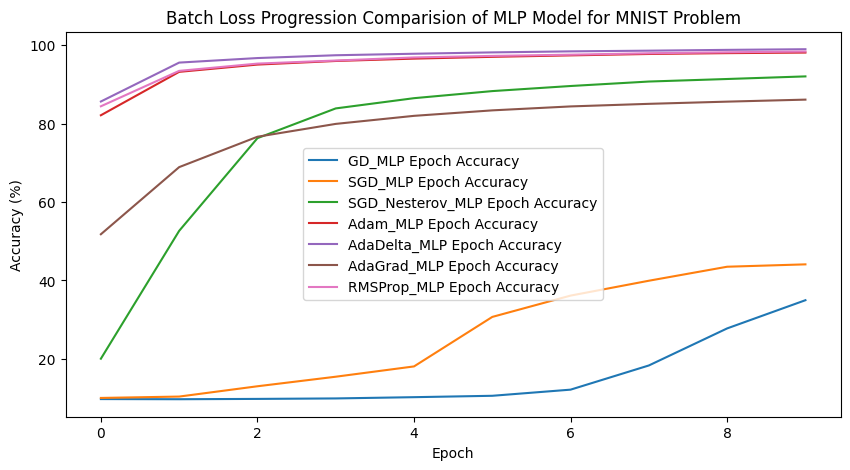

In [56]:
plot_epoch_accuracies(epoch_accs_map, "Batch Loss Progression Comparision of MLP Model for MNIST Problem")

## VGG

### Kiến trúc VGG-MNIST

#### Tổng quan
Một mạng nơ-ron tích chập lấy cảm hứng từ VGG, được thiết kế gọn nhẹ và thích ứng cho bộ dữ liệu MNIST.  
Kiến trúc này tuân theo nguyên tắc thiết kế của VGG‑16 nhưng được thu nhỏ để xử lý hiệu quả ảnh xám 28×28.

#### Chi tiết kiến trúc

##### Thích ứng đầu vào
- **Tích chập 1×1** mở rộng ảnh MNIST (1 kênh) thành **3 kênh**.

##### Backbone (Bộ trích xuất đặc trưng)
- **Khối 1 (28 → 14):**
  - Conv2d(3 → 64, kernel=3, padding=1) → BatchNorm → ReLU  
  - Conv2d(64 → 64, kernel=3, padding=1) → BatchNorm → ReLU  
  - MaxPool2d(2×2, stride=2)

- **Khối 2 (14 → 7):**
  - Conv2d(64 → 128, kernel=3, padding=1) → BatchNorm → ReLU  
  - Conv2d(128 → 128, kernel=3, padding=1) → BatchNorm → ReLU  
  - MaxPool2d(2×2, stride=2)

- **Khối 3 (7 → 3):**
  - Conv2d(128 → 256, kernel=3, padding=1) → BatchNorm → ReLU  
  - Conv2d(256 → 256, kernel=3, padding=1) → BatchNorm → ReLU  
  - MaxPool2d(2×2, stride=2)

##### Bộ phân loại (Fully Connected Layers)
- Flatten: **256 × 3 × 3 → 2304 đặc trưng**  
- Linear(2304 → 128) → ReLU → Dropout(0.5)  
- Linear(128 → 64) → ReLU → Dropout(0.5)  
- Linear(64 → 10) → Đầu ra logits cho 10 lớp MNIST

#### Số lượng tham số
- Tổng số tham số: **~1–2 triệu** (nhỏ hơn nhiều so với VGG‑16 ~138M).  
- Được thiết kế để cân bằng giữa **độ sâu và hiệu quả** cho MNIST.

#### Mục đích
- Cung cấp một **mạng sâu gọn nhẹ theo phong cách VGG** cho MNIST.  
- Hữu ích để đánh giá cách các bộ tối ưu khác nhau hoạt động trên kiến trúc có độ sâu vừa phải.  
- Giữ nguyên **triết lý thiết kế VGG** (các lớp tích chập 3×3 xếp chồng + ReLU + pooling) trong khi vẫn khả thi về tính toán cho ảnh nhỏ.

In [ ]:
class VGG_MNIST(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_MNIST, self).__init__()

        # Input adaptation: 1 → 3 channels
        self.input_adapter = nn.Conv2d(1, 3, kernel_size=1)

        # Lightweight VGG backbone (only 3 blocks for 28×28)
        self.features = nn.Sequential(
            # Block 1: 28 → 14
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 14 → 7
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 7 → 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers (smaller than original VGG)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 3 * 3, 128),   # flatten from 3×3 feature map
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.input_adapter(x)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [64]:
# Create separate models for each optimizer
vgg_gd_model = VGG_MNIST().to(device)
vgg_sgd_model = VGG_MNIST().to(device)
vgg_sgd_nesterov_model = VGG_MNIST().to(device)
vgg_adam_model = VGG_MNIST().to(device)
vgg_adadelta_model = VGG_MNIST().to(device)
vgg_adagrad_model = VGG_MNIST().to(device)
vgg_rmsprop_model = VGG_MNIST().to(device)

models_vgg = {
    "GD_VGG16": vgg_gd_model,
    "SGD_VGG16": vgg_sgd_model,
    "SGD_Nesterov_VGG16": vgg_sgd_nesterov_model,
    "Adam_VGG16": vgg_adam_model,
    "AdaDelta_VGG16": vgg_adadelta_model,
    "AdaGrad_VGG16": vgg_adagrad_model,
    "RMSProp_VGG16": vgg_rmsprop_model
}

lr = 0.001

optimizers_vgg = {
    "GD_VGG16": optim.SGD(vgg_gd_model.parameters(), lr=lr),
    "SGD_VGG16": optim.SGD(vgg_sgd_model.parameters(), lr=lr),
    "SGD_Nesterov_VGG16": optim.SGD(vgg_sgd_nesterov_model.parameters(), lr=lr, momentum=0.9, nesterov=True),
    "Adam_VGG16": optim.Adam(vgg_adam_model.parameters(), lr=lr),
    "AdaDelta_VGG16": optim.Adadelta(vgg_adadelta_model.parameters()),
    "AdaGrad_VGG16": optim.Adagrad(vgg_adagrad_model.parameters(), lr=lr),
    "RMSProp_VGG16": optim.RMSprop(vgg_rmsprop_model.parameters(), lr=lr)
}


Trong giai đoạn tiếp theo của nghiên cứu, chúng ta mở rộng các thí nghiệm sang một mạng nơ-ron tích chập theo phong cách VGG. Khác với MLP, các kiến trúc VGG được thiết kế chuyên biệt cho dữ liệu hình ảnh và do đó hiệu quả hơn trong việc nắm bắt các cấu trúc không gian và mẫu cục bộ.  

Dựa trên lợi thế thiết kế này, chúng tôi dự đoán rằng tất cả các bộ tối ưu sẽ mang lại hiệu suất cải thiện hơn trên tác vụ phân loại MNIST khi áp dụng cho VGG so với mô hình MLP cơ sở.  

Để đảm bảo sự so sánh công bằng, thiết lập thí nghiệm — bao gồm số lượng epoch huấn luyện, lựa chọn hàm mất mát và giao thức đánh giá — sẽ được giữ nguyên như trong các thí nghiệm với MLP. Sự nhất quán này cho phép chúng ta cô lập tác động của sự khác biệt về kiến trúc và trực tiếp đối chiếu hành vi tối ưu hóa giữa hai mô hình.

In [65]:
epoch_accs_map_vgg = {}

for name in models_vgg:
    batch_metrics = train_model(models_vgg[name], optimizers_vgg[name], train_dl, val_dl, model_name=name)
    
    epoch_accs = []
    for epoch in range(1, 11):
        epoch_batches = [m for m in batch_metrics if m["epoch"] == epoch]
        avg_acc = sum(m["accuracy"] for m in epoch_batches) / len(epoch_batches)
        epoch_accs.append(avg_acc)
    
    epoch_accs_map_vgg[name] = epoch_accs
    
    test_model(models_vgg[name], test_dl)


Training with GD_VGG16...
Epoch 1/10 - Train Loss: 1.8694, Train Acc: 38.89% | Val Loss: 1.0542, Val Acc: 87.50%
Epoch 2/10 - Train Loss: 1.0316, Train Acc: 69.20% | Val Loss: 0.3898, Val Acc: 94.93%
Epoch 3/10 - Train Loss: 0.6129, Train Acc: 82.49% | Val Loss: 0.1889, Val Acc: 96.53%
Epoch 4/10 - Train Loss: 0.4274, Train Acc: 88.13% | Val Loss: 0.1203, Val Acc: 97.31%
Epoch 5/10 - Train Loss: 0.3288, Train Acc: 91.09% | Val Loss: 0.0912, Val Acc: 97.77%
Epoch 6/10 - Train Loss: 0.2659, Train Acc: 93.01% | Val Loss: 0.0749, Val Acc: 98.03%
Epoch 7/10 - Train Loss: 0.2236, Train Acc: 94.05% | Val Loss: 0.0655, Val Acc: 98.25%
Epoch 8/10 - Train Loss: 0.1975, Train Acc: 94.84% | Val Loss: 0.0580, Val Acc: 98.33%
Epoch 9/10 - Train Loss: 0.1770, Train Acc: 95.40% | Val Loss: 0.0537, Val Acc: 98.48%
Epoch 10/10 - Train Loss: 0.1586, Train Acc: 95.88% | Val Loss: 0.0480, Val Acc: 98.60%
Final Test Loss: 0.0398 | Final Test Acc: 98.8000%

Training with SGD_VGG16...
Epoch 1/10 - Train Loss

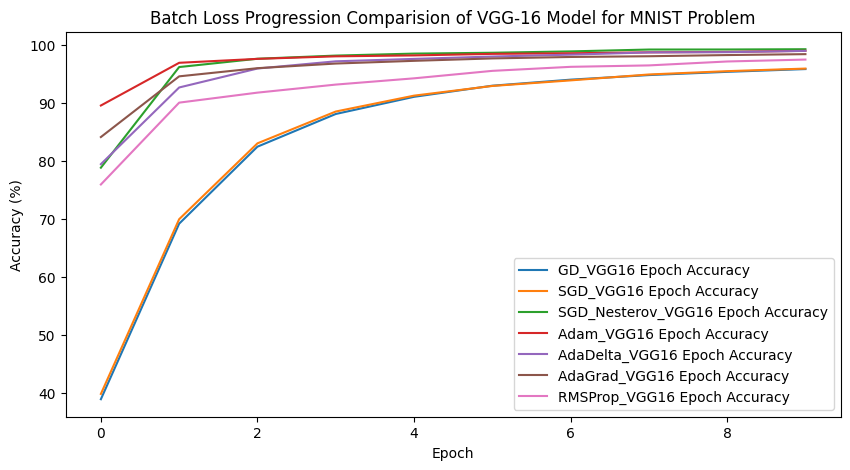

In [66]:
plot_epoch_accuracies(epoch_accs_map_vgg, "Batch Loss Progression Comparision of VGG-16 Model for MNIST Problem")

In [69]:
import pandas as pd
def conclude_saved_models(model_paths, train_loader, val_loader, test_loader):
    results = []
    criterion = nn.CrossEntropyLoss()

    for name, path in model_paths.items():
        # Load the full model object directly
        model = torch.load(path, weights_only=False).to(device)
        model.eval()

        # --- Train metrics ---
        train_loss, train_correct, train_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                train_correct += (predicted == labels).sum().item()
                train_total += labels.size(0)
        train_loss /= train_total
        train_acc = 100 * train_correct / train_total

        # --- Validation metrics ---
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        # --- Test metrics ---
        test_loss, test_correct, test_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)
        test_loss /= test_total
        test_acc = 100 * test_correct / test_total

        results.append({
            "Optimizer": name,
            "Final Train Loss": round(train_loss, 4),
            "Final Train Acc (%)": round(train_acc, 4),
            "Final Val Loss": round(val_loss, 4),
            "Final Val Acc (%)": round(val_acc, 4),
            "Final Test Loss": round(test_loss, 4),
            "Final Test Acc (%)": round(test_acc, 4)
        })

    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    return df

In [70]:
mlp_model_paths = {
    "AdaDelta": "AdaDelta_MLP.pt",
    "AdaGrad": "AdaGrad_MLP.pt",
    "Adam": "Adam_MLP.pt",
    "GD (Gradient Descent)": "GD_MLP.pt",
    "SGD": "SGD_MLP.pt",
    "SGD + Nesterov": "SGD_Nesterov_MLP.pt",
    "RMSProp": "RMSProp_MLP.pt"
}

summary_mlp = conclude_saved_models(mlp_model_paths, train_dl, val_dl, test_dl)

            Optimizer  Final Train Loss  Final Train Acc (%)  Final Val Loss  Final Val Acc (%)  Final Test Loss  Final Test Acc (%)
             AdaDelta            0.0206              99.4188          0.1134            97.4417           0.1103               97.42
              AdaGrad            0.4797              86.3312          0.4781            86.4917           0.4677               86.86
                 Adam            0.0453              98.6292          0.1175            96.8417           0.1110               96.76
GD (Gradient Descent)            2.2377              37.6229          2.2373            37.6667           2.2352               37.68
                  SGD            2.0973              43.8312          2.0970            43.8000           2.0923               44.13
       SGD + Nesterov            0.2654              92.3750          0.2807            92.0250           0.2674               92.18
              RMSProp            0.0384              98.8854         

In [71]:
vgg_model_paths = {
    "AdaDelta": "AdaDelta_VGG16.pt",
    "AdaGrad": "AdaGrad_VGG16.pt",
    "Adam": "Adam_VGG16.pt",
    "GD (Gradient Descent)": "GD_VGG16.pt",
    "SGD": "SGD_VGG16.pt",
    "SGD + Nesterov": "SGD_Nesterov_VGG16.pt",
    "RMSProp": "RMSProp_VGG16.pt"
}

summary_vgg = conclude_saved_models(vgg_model_paths, train_dl, val_dl, test_dl)


            Optimizer  Final Train Loss  Final Train Acc (%)  Final Val Loss  Final Val Acc (%)  Final Test Loss  Final Test Acc (%)
             AdaDelta            0.0081              99.8063          0.0482            99.3083           0.0402               99.45
              AdaGrad            0.0059              99.8542          0.0267            99.3083           0.0225               99.29
                 Adam            0.0116              99.7208          0.0507            99.2167           0.0360               99.39
GD (Gradient Descent)            0.0403              98.8333          0.0480            98.6000           0.0398               98.80
                  SGD            0.0416              98.8063          0.0486            98.5667           0.0428               98.70
       SGD + Nesterov            0.0073              99.7521          0.0371            99.1667           0.0293               99.30
              RMSProp            0.0140              99.6479         

## Kết luận
Sau quá trình huấn luyện và đánh giá chuyên sâu trên bộ dữ liệu MNIST, kết quả cho thấy rằng:  

- **AdaDelta** liên tục thể hiện hiệu suất mạnh mẽ trên cả hai kiến trúc. Trên VGG, nó đạt hội tụ xuất sắc với độ chính xác kiểm tra cuối cùng là **99.45%**, trong khi trên MLP vẫn duy trì mức cạnh tranh ở **97.42%**. Cơ chế tốc độ học thích ứng giúp AdaDelta giữ ổn định và giá trị mất mát thấp, khiến nó trở thành một trong những bộ tối ưu đáng tin cậy nhất trong nghiên cứu này.  

- **AdaGrad** cho thấy sự tương phản rõ rệt giữa hai mô hình. Trên VGG, nó hoạt động rất tốt, đạt độ chính xác kiểm tra **99.29%**, nhưng trên MLP lại sụt giảm mạnh chỉ còn **86.86%**. Điều này cho thấy xu hướng của AdaGrad trong việc giảm tốc độ học hiệu quả quá nhanh theo thời gian, có thể cản trở hiệu suất trong các lần huấn luyện dài hoặc kiến trúc đơn giản, mặc dù nó nổi bật trong các mô hình tích chập sâu.  

- **Adam** mang lại kết quả ổn định và cao, với độ chính xác kiểm tra **99.39%** trên VGG và **96.76%** trên MLP. Cơ chế ước lượng mô-men thích ứng giúp Adam hội tụ nhanh chóng và ổn định, mặc dù hiệu suất trên MLP hơi thấp hơn AdaDelta và RMSProp. Nhìn chung, Adam vẫn là một bộ tối ưu đa dụng mạnh mẽ, đặc biệt hiệu quả trong các kiến trúc phức tạp.  

- **Gradient Descent (GD) thuần túy** đạt mức chấp nhận được trên VGG (**98.80%**), nhưng thất bại nghiêm trọng trên MLP, chỉ đạt **37.68%**. Không có tính thích ứng hay động lượng, GD gặp khó khăn trong việc hội tụ ở kiến trúc nông, nhấn mạnh những hạn chế của nó khi áp dụng cho mạng nơ-ron hiện đại mà không có cải tiến bổ sung.  

- **SGD thuần túy** phản ánh hành vi của GD: chấp nhận được trên VGG (**98.70%**) nhưng kém trên MLP (**44.13%**). Việc thiếu động lượng hoặc cơ chế thích ứng khiến nó không ổn định trong mô hình đơn giản, cho thấy SGD thuần túy không đủ để đảm bảo hội tụ đáng tin cậy trong thiết lập thí nghiệm này.  

- **SGD với động lượng Nesterov** đã biến đổi hiệu suất rõ rệt. Trên VGG, nó đạt **99.30%**, và trên MLP cải thiện mạnh mẽ lên **92.18%**, vượt xa SGD thuần túy. Điều này chứng minh vai trò quan trọng của động lượng trong việc ổn định cập nhật và tăng tốc hội tụ, đặc biệt ở các mạng nông.  

- **RMSProp** chứng tỏ là một trong những bộ tối ưu nhất quán nhất. Nó đạt độ chính xác kiểm tra **99.26%** trên VGG và **97.11%** trên MLP, với giá trị mất mát cuối cùng thấp trong cả hai trường hợp. Bằng cách duy trì trung bình động của gradient bình phương, RMSProp cân bằng giữa tính thích ứng và sự ổn định, khiến nó trở thành lựa chọn mạnh mẽ trên nhiều kiến trúc.  


### Tổng hợp
Tất cả những quan sát này cho thấy lựa chọn bộ tối ưu đóng vai trò quyết định trong kết quả huấn luyện. Các phương pháp thích ứng như **AdaDelta, Adam, RMSProp**, cùng với **SGD kết hợp động lượng Nesterov**, liên tục mang lại hiệu suất mạnh mẽ và đáng tin cậy trên cả hai kiến trúc. Trong khi đó, **GD thuần túy** và **SGD thuần túy** tỏ ra không đủ trong thiết lập MLP, còn **AdaGrad** thể hiện sự nhạy cảm với độ sâu của mô hình.  

Sự tương phản giữa kết quả trên VGG và MLP cho thấy các mạng tích chập sâu có thể bù đắp cho những bộ tối ưu yếu hơn, nhưng chỉ các phương pháp thích ứng hoặc dựa trên động lượng mới đảm bảo sự ổn định và độ chính xác cao trong nhiều bối cảnh.  

**Kết luận:** Mặc dù kiến trúc mô hình ảnh hưởng đến hiệu suất tổng thể, chính bộ tối ưu mới là yếu tố quyết định việc huấn luyện có hội tụ hiệu quả hay không, khiến việc lựa chọn bộ tối ưu trở thành yếu tố then chốt cho thành công của mạng nơ-ron.